In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nib
import seaborn as sns
from scipy import stats
from nilearn import plotting
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_decomposition import PLSRegression
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, f1_score

# 1. LESION FREQUENCY MAPS

In [2]:
path_lesion='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/Lesion_PD/PD_core/*gz'
frequency_lesion = glob.glob(path_lesion)
freqLES=[]
for x in frequency_lesion:
    d=nib.load(x).get_fdata().flatten()
    freqLES.append(d)
aff_freq=nib.load(frequency_lesion[0]).affine
df_freq=pd.DataFrame(freqLES)
df_freq=df_freq.T

frequency_map=np.asarray(df_freq.sum(axis=1))
mapnii1_freq=frequency_map.reshape(91,109,91)
mapfinal1_freq = nib.nifti1.Nifti1Image(mapnii1_freq, aff_freq)
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/'
save_freq=dirpath+'frequency_map.nii.gz'
nib.save(mapfinal1_freq, save_freq)

- Load Each Lesion Mask and Flatten It (to 1D vector)

- Extract **Affine Transformation Matrix**: This matrix ensures that the output frequency map maintains the same spatial orientation
- After transposition:
    - *Row*: a single voxel postion across all patients

    - *Column*: patient's lesion data

- Frequency map is computed
- Reshape back to 3D Space
- Save as NIfTI File

# 2. FUNCTIONAL CONNECTIVITY ANALYSIS

All subjects 

#### Load Functional Connectivity Maps

In [3]:
path='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/the_99_subjs/*gz'
mapsPCFDC=[]
files=glob.glob(path)
files.sort()

#### Flatten and store data

In [ ]:
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)

#### Affine Matrix and Threshold Mask

In [ ]:
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

df = df.mask(df < 0.2, 0) # MAKS VALUES LOWER THAN 0.2

In [5]:
files_ = [sub.replace('/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99_subjs/meanFC.', '') for sub in files]
files_ = [sub.replace('.nii.gz', '') for sub in files_]
df_fdc=df.T
df_fdc.insert(loc = 0, column = 'CODE', value = files_)

# 3. PCA ON ALL SUBJECTS

> *Finally, we checked the classification accuracy of network disconnectivity patterns in predicting patients belonging to the low, intermediate, or high survival group. To this end, a principal component analysis (PCA) was applied to the thresholded (conservative) network maps (in voxel space). Kaiser-Meyer-Olkin (KMO) test was run to test the sampling adequacy of the PCA.*

- Principal Component Analysis (PCA) is applied to reduce the dimensionality of brain connectivity data while retaining only the components that explain **>90% of the variance**.

- The Kaiser-Meyer-Olkin (KMO) measure is computed to test sample **adequacy** (The closer to 1, the more suitable the data is for PCA).

- These PCs serve as **features** for clustering and classification.


#### Compute PCA

In [ ]:
pca_PCFDC=PCA(n_components=40)
pca_components=pca_PCFDC.fit_transform(df)

/home/lorenzo/anaconda3/envs/caps/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


kmo is kmo=0.991



#### Compute KMO Measure

In [ ]:
mo_all,kmo_model=calculate_kmo(df)
text= 'kmo='+str(round(kmo_model,3))
print('kmo is', text)
print('')

#### Plot Variance Explained

[71.96741946  8.52652083  4.67382294  3.40200152  2.00542294  1.41344707
  1.05441436  0.86187328  0.75063519  0.61106059]


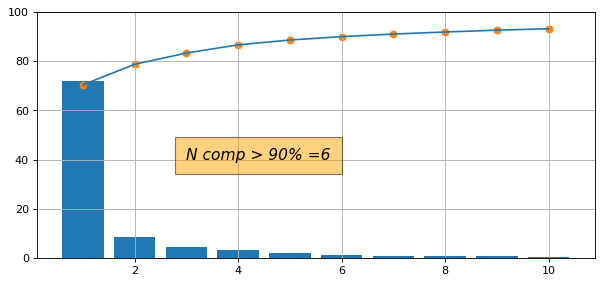

In [ ]:
# Variance explained by each component
percentage_var_explained = pca_PCFDC.explained_variance_ / np.sum(pca_PCFDC.explained_variance_)
percentage_var_explained100=percentage_var_explained*100
cum_var_dist=np.cumsum(pca_PCFDC.explained_variance_ratio_)

# Parameters
n_comp=10
g=cum_var_dist[:n_comp]*100
y=np.arange(1,n_comp+1)
perc=percentage_var_explained100[0:n_comp]

# Plotting
plt.figure(figsize=(9, 4), dpi=80)
plt.bar(y,perc)
plt.grid()
plt.scatter(y,g)
plt.plot(y,g)
plt.ylim([0, 100])

# Bumber of components explaining more than 90% variance
lll=np.where(cum_var_dist>0.90)[0][0]
text2='N comp > 90% ='+str(lll)
text_kwargs = dict(fontsize=14)
#plt.text(0.9, 50, text_voxel_unflip, style='italic', **text_kwargs,
#        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
plt.text(3, 40, text2, style='italic', fontsize=14,
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
m='PCFDC_PCA_variance_all_cohort.png'
plt.savefig(m, dpi=300, bbox_inches='tight')
print(percentage_var_explained100[0:10])

- Bar Plot: Each bar represents the variance explained by each principal component (PC).

- Line and Scatter Plot: This represents the cumulative variance explained.

#### Save and Visualize Principal Component

##### PC1

In [ ]:
# Extract the PCA component and convert to a dataframe
pc1=pca_components[:,0]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']

# Create and save NIfTI Image
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC1_ALL.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)

# Visualize
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=2.8, colorbar=False)
#plt.savefig('AHP_AS_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.show()

`pc1` is a 1D array containing PC scores for each voxel. 

Than it is copied into a column of the `comp1`, where each row corresponds to a voxel.

In the end:

- `parcel` contains the index of each voxel

- `Scores` contains the PCA score assigned to that voxel 


##### PC2

In [ ]:
pc1=pca_components[:,1]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC2_ALL.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=1, colorbar=False)
#plt.savefig('AHP_AS_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.show()

##### PC3

In [ ]:
pc1=pca_components[:,2]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC3_ALL.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.8, colorbar=False)
#plt.savefig('AHP_AS_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.show()

##### PC4

In [ ]:
pc1=pca_components[:,3]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC4_ALL.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.6, colorbar=False)
#plt.savefig('AHP_AS_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.show()

##### PC5

In [ ]:
pc1=pca_components[:,4]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC5_ALL.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.6, colorbar=False)
#plt.savefig('AHP_AS_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. BRAIN VISUALIZATION AND DATA PROCESSING

In [ ]:
%gui qt
from nibabel.freesurfer.mghformat import load
from surfer import Brain, project_volume_data
from mayavi import mlab

#### Load Surface Data


In [ ]:
brain = Brain("fsaverage", "split", "pial",
              views=['lat', 'med'], background="white", 
              subjects_dir='/usr/local/freesurfer/7.3.2/subjects')

mri_file = "PC4_ALL.nii.gz"
reg_file = "/usr/local/freesurfer/7.3.2/average/mni152.register.dat"

surf_data_lh = project_volume_data(mri_file, "lh", reg_file)
surf_data_rh = project_volume_data(mri_file, "rh", reg_file)

brain.add_overlay(surf_data_lh, min=0, max=1, name="ang_corr_lh", hemi='lh')
brain.add_overlay(surf_data_rh, min=0, max=1, name="ang_corr_rh", hemi='rh')

#brain.save_image("CAP1_ALL.png")

- Initialize the Brain Visualization

- Load the MRI Volume Data

- Project Volume Data onto the Surface

- Add Overlays to the Brain Visualization

#### Assign Labels

Load and Clean Subject IDs

In [8]:
dataset=pd.DataFrame({'ID':files})
dataset['ID']=dataset['ID'].replace({'/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/the_99_subjs/meanFC.':''},regex=True)
dataset['ID']=dataset['ID'].replace({'.nii.gz':''},regex=True)
dataset.head(5)

,ID
0,005_STE_L
1,009_MAR_F
2,010_TRE_L
3,011_BID_A
4,012_ART_L


Load Subject Groups

In [ ]:
low_p='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/list_LOW.txt'
low= [line.rstrip('\n') for line in open(low_p)]
high_p='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/list_HIGH.txt'
high= [line.rstrip('\n') for line in open(high_p)]
inter_p='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/list_INTERMEDIATE.txt'
inter= [line.rstrip('\n') for line in open(inter_p)]

dataset.loc[dataset['ID'].isin(low), 'Label'] = 'low'
dataset.loc[dataset['ID'].isin(high), 'Label'] = 'high'
dataset.loc[dataset['ID'].isin(inter), 'Label'] = 'intermediate'

,ID,Label,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,005_STE_L,high,0.125952,-0.029257,0.167612,-0.130413,-0.131117,0.117985,-0.137948,-0.130988,...,-0.006717,0.014883,0.006857,0.022439,0.086896,0.130373,-0.127199,-0.012239,0.137043,-0.032631
1,009_MAR_F,intermediate,0.140216,-0.012328,0.182610,-0.128450,-0.054053,0.074371,-0.058660,-0.001223,...,-0.134277,0.110658,0.164191,0.029359,0.063195,0.079087,-0.143039,0.013492,-0.029945,0.082057
2,010_TRE_L,intermediate,0.110356,0.181964,-0.093217,-0.052826,-0.035364,-0.041092,0.093461,-0.002396,...,-0.028143,0.059296,0.018308,-0.037231,-0.080368,0.021258,-0.045668,-0.004231,-0.012876,0.004702
3,011_BID_A,intermediate,0.119174,0.109479,0.131183,-0.172851,0.125863,-0.046533,0.038664,0.061033,...,-0.121026,-0.056377,-0.002187,-0.069690,0.008867,0.083061,-0.060257,0.026471,0.069314,-0.096858


#### Compute PCA Components

In [ ]:
comp_df=pca_PCFDC.components_
COMP=pca_PCFDC.components_
comp_df=pd.DataFrame(COMP)
N=comp_df.T
N.insert(0, 'Label', dataset['Label'])
N.insert(0, 'ID', dataset['ID'])
N.head(4)

Convert PCA Component Loadings into a DataFrame. `pca_PCFDC.components_` is a matrix where

- *Rows*: Correspond to the original features

- *Columns*: Correspond to the principal components

Insert Labels and Subject IDs




# 5. CLUSTERING ANALYSIS

> *The PCs explaining >90% of the variance were used as features in a Kmeans algorithm. Each time we executed the Kmeans algorithm, we evaluated  two groups to examine the alignment between OS groups (n = 2) and connectivity-based clusters (fixed at k = 2). The OS groups were subsequently compared in pairs to evaluate the consistency between survival stratification and connectivity-based clusters. Classification accuracy was then computed. The same analysis was performed considering the (liberal) unthresholded maps. To ensure the prediction was not influenced by the algorithm selection, we also run a linear discriminant analysis (LDA) with leave-one-out hyperparameter validation (solver: singular value decomposition; least squares; eigenvalue decomposition) splitting the dataset into train (using the 60% of the total dataset) and test sets. The same approach, comparing each time two groups with two connectivity-classes, was adopted considering the original classification of the three OS groups.*


##### K-Means

- K-Means is an unsupervised learning algorithm that groups subjects based on their connectivity patterns.

- Each subject is assigned to one of k clusters.

- Instead of clustering on thousands of voxel values, we cluster based on only a few PCs.





## K-Means and LDA

- K-Means clustering is applied with k=2, meaning we force the data into two clusters based on functional connectivity patterns.

- This step is unsupervised, meaning OS labels are NOT used in clustering --> the model **naturally** groups subjects based on connectivity patterns.

- Each time in the dataset one survival group is filtered out. The goal is to check how well clustering aligns with different pairs of survival groups (Low, Intermediate, High).

- LDA (Linear Discriminant Analysis) is **supervised** because it is explicitly trained using OS labels to find the best separation between survival groups.


### High vs low

#### K-Means Clustering

(55, 5)
accuracy 0.5454545454545454
balanced accuracy 0.5795454545454546
f1_score 0.5008043599592895


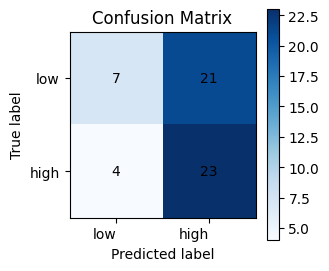

In [ ]:
# Filters out intermediate subjects
Na = N[N.Label!='intermediate']
cluster=2

# Extracts PCA components
X=np.asarray(Na.iloc[:,2:7])
print(X.shape)

# Performs K-Means clustering
kmeans = KMeans(n_clusters=cluster, random_state=1)
y_pred = kmeans.fit_predict(X)

# Maps ground truth labels
Y=np.asarray(Na.Label)
mapping = {'low': 1, 'high': 0}
Y = [mapping[s] for s in Y]

In [ ]:
# Evaluates clustering performance
print('accuracy', accuracy_score(y_pred, Y))
print('balanced accuracy', balanced_accuracy_score(y_pred, Y))
print('f1_score', f1_score(Y, y_pred, average='weighted'))

In [ ]:
# Plots confusion matrix
cm = confusion_matrix(Y, y_pred)
labels = ['low', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_high_vs_low.png', dpi=300)
plt.show()

#### Linear Discriminant Analysis (LDA)

lsqr
whole cohort 0.5818181818181818
test set 0.5
test set balanced accuracy 0.5256410256410257


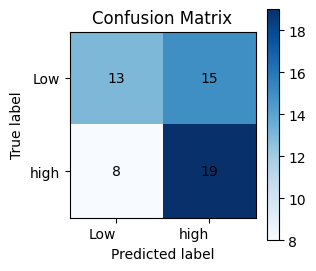

In [ ]:
y=Na.Label
X=Na.iloc[:,2:7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

lda = LinearDiscriminantAnalysis()

# Define hyperparameter grid for solver selection
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']}

# Use Leave-One-Out cross-validation (LOO) for hyperparameter tuning
loo = LeaveOneOut()
grid_search = GridSearchCV(lda, param_grid, cv=loo)
grid_search.fit(X_train, y_train)
best_lda_model = grid_search.best_estimator_
print(grid_search.best_estimator_.solver)

# Predict labels on test set
y_lda_pred = best_lda_model.predict(X_test)
# Compute overall test accuracy
test_accuracy = np.mean(y_lda_pred == y_test)

# Predict labels on the whole dataset
y_lda_pred_tot = best_lda_model.predict(X)


In [ ]:
# Mapping
mapping = {'low': 1, 'high': 0}

Y = [mapping[s] for s in y]
Yhat_tot = [mapping[s] for s in y_lda_pred_tot]

Ytest = [mapping[s] for s in y_test]
Yhat = [mapping[s] for s in y_lda_pred]

In [ ]:
# Print accuracy metrics
print('whole cohort', accuracy_score(Yhat_tot, Y))
print('test set', accuracy_score(Yhat, Ytest))
print('test set balanced accuracy', balanced_accuracy_score(Yhat, Ytest))

#print(f1_score(Ytest, Yhat, average='weighted'))

In [ ]:
# Confusion matrix Plot
cm = confusion_matrix(Y, Yhat_tot)
labels = ['Low', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('LDA_high_vs_low.png', dpi=300)
plt.show()

### High vs Intermediate

#### K-Means

(72, 5)
accuracy 0.5138888888888888
balanced accuracy 0.4607843137254902
f1_score 0.4970760233918128


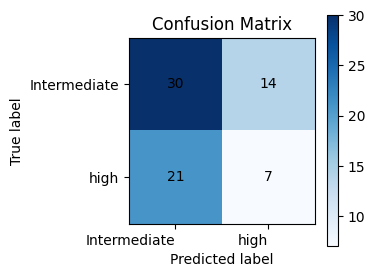

In [ ]:
# Filters out low
Na=N[N.Label!='low']
cluster=2
X=np.asarray(Na.iloc[:,2:7])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.Label)

# Mapping
mapping = {'intermediate': 0, 'high': 1}
Y = [mapping[s] for s in Y]

# Evaluation
print('accuracy', accuracy_score(y_pred, Y))
print('balanced accuracy', balanced_accuracy_score(y_pred, Y))
print('f1_score', f1_score(Y, y_pred, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, y_pred)
labels = ['Intermediate', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_high_vs_intermediate.png', dpi=300)
plt.show()

#### LDA

whole cohort 0.5972222222222222
test set 0.5172413793103449
test set balanced accuracy 0.452020202020202


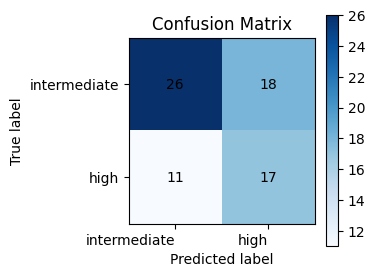

In [ ]:
# Model
y=Na.Label
X=Na.iloc[:,2:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, 
                                                    shuffle=True)
lda = LinearDiscriminantAnalysis()

# Fine tuning
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']}
loo = LeaveOneOut()
grid_search = GridSearchCV(lda, param_grid, cv=loo)
grid_search.fit(X_train, y_train)

best_lda_model = grid_search.best_estimator_

# Prediction
y_lda_pred = best_lda_model.predict(X_test)
test_accuracy = np.mean(y_lda_pred == y_test)
y_lda_pred_tot = best_lda_model.predict(X)

# Mapping
mapping = {'intermediate': 0, 'high': 1}

Y = [mapping[s] for s in y]
Yhat_tot = [mapping[s] for s in y_lda_pred_tot]

Ytest = [mapping[s] for s in y_test]
Yhat = [mapping[s] for s in y_lda_pred]

# Evaluation
print('whole cohort', accuracy_score(Yhat_tot, Y))
print('test set', accuracy_score(Yhat, Ytest))
print('test set balanced accuracy', balanced_accuracy_score(Yhat, Ytest))
#print(f1_score(Ytest, Yhat, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, Yhat_tot)
labels = ['intermediate', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('LDA_high_vs_intermediate.png', dpi=300)
plt.show()

### Low vs Intermediate

#### K-Means

(71, 5)
accuracy 0.5633802816901409
balanced accuracy 0.47175141242937857
f1_score 0.5112076491811212


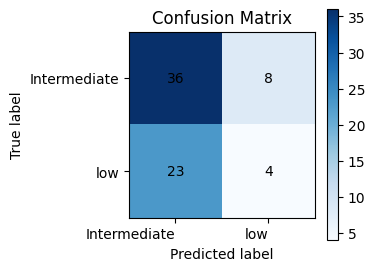

In [ ]:
# Filters out high
Na=N[N.Label!='high']
cluster=2
X=np.asarray(Na.iloc[:,2:7])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.Label)

# Mapping
mapping = {'intermediate': 0, 'low': 1}
Y = [mapping[s] for s in Y]

# Evaluation
print('accuracy', accuracy_score(y_pred, Y))
print('balanced accuracy', balanced_accuracy_score(y_pred, Y))
print('f1_score', f1_score(Y, y_pred, average='weighted'))

# Confusion matrix 
cm = confusion_matrix(Y, y_pred)
labels = ['Intermediate', 'low']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_low_vs_intermediate.png', dpi=300)
plt.show()

#### LDA

whole cohort 0.647887323943662
test set 0.5172413793103449


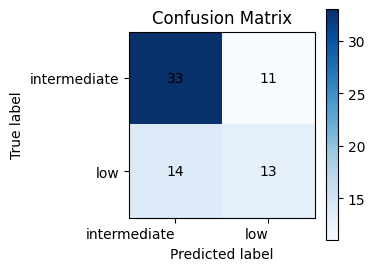

In [ ]:
# LDA
y=Na.Label
X=Na.iloc[:,2:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, 
                                                    shuffle=True)
lda = LinearDiscriminantAnalysis()
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']}

# Fine tuning
loo = LeaveOneOut()
grid_search = GridSearchCV(lda, param_grid, cv=loo)
grid_search.fit(X_train, y_train)

best_lda_model = grid_search.best_estimator_

y_lda_pred = best_lda_model.predict(X_test)
test_accuracy = np.mean(y_lda_pred == y_test)
y_lda_pred_tot = best_lda_model.predict(X)

# Mapping
mapping = {'intermediate': 0, 'low': 1}

Y = [mapping[s] for s in y]
Yhat_tot = [mapping[s] for s in y_lda_pred_tot]

Ytest = [mapping[s] for s in y_test]
Yhat = [mapping[s] for s in y_lda_pred]

# Evaluation
print('whole cohort', accuracy_score(Yhat_tot, Y))
print('test set', accuracy_score(Yhat, Ytest))
print('test set balanced accuracy', balanced_accuracy_score(Yhat, Ytest))
#print(f1_score(Ytest, Yhat, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, Yhat_tot)
labels = ['intermediate', 'low']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('LDA_low_vs_intermediate.png', dpi=300)
plt.show()

## Different stratifications + K-Means

> *Additionally, the Kmeans analysis was repeated considering the extreme groups (lowest vs highest survivors) using different OS percentile for the stratification: i) 50th percentile; ii) 25th and 75th percentiles; and 20th and 80th percentiles.*

- The dataset contains OS (Overall Survival) in months.

- The OS values are inserted into `N`, which contains brain connectivity features (PCA components), as before.


In [47]:
dataset_OS=pd.read_excel('OS_the_99_subjs.xlsx')
dataset_OS.head(5)
N.insert(1, 'OS', dataset_OS.OS_months)

In [ ]:
# Compute quartiles (25th, 50th, and 75th percentile) for OS values
percentileOS=np.percentile(N.OS, [25, 50, 75])

# Create a binary classification of OS: "Low" if below median, "High" otherwise
a = ['Low' if x < percentileOS[1] else 'High' for x in N.OS]

# Create a 4-category classification of OS based on quartiles
b = ['Low' if x < percentileOS[0] else 'modlow' if x < percentileOS[1] else 'modhigh' 
     if x < percentileOS[2] else 'high' for x in N.OS]

# Compute quintiles (20th, 40th, 60th, 80th percentile)
percentileOS_5=np.percentile(N.OS, [20, 40, 60, 80])

# Create a 5-category classification of OS based on quintiles
c = ['LowLow' if x < percentileOS_5[0] else 'Low' if x < percentileOS_5[1] else 'moderate' 
     if x < percentileOS_5[2] else 'High' if x < percentileOS_5[3] else 'HighHigh' for x in N.OS]

# Insert newly created categorical labels into the dataset
N.insert( 3, 'k_2', a)
N.insert( 4, 'k_4', b)
N.insert( 5, 'k_5', c)

Again, the goal of this analysis is to investigate whether functional connectivity patterns can naturally differentiate survival groups using unsupervised clustering (K-Means).


Different stratifications:

- **Binary Stratification**: 

    - Simplifies OS comparison into "Low" vs. "High" groups.

    - K-Means is applied with k=2.

    - The clusters are compared with the binary OS labels.


- **Quartiles**: 

    - Captures finer OS variations, allowing for a 4-tier classification.

        - Low (0-25%)
        
        - Mod-Low (25-50%)
        
        - Mod-High (50-75%)
        
        - High (75-100%)

    - K-Means is applied with k=4.
    
    - The clusters are compared with the quartile OS labels.


- **Quintiles**: 

    - Provides even more detailed survival differentiation.

        - Low-Low.

        - Low.

        - Moderate.

        - High.

        - High-High.


    - K-Means is applied with k=5.


These OS Categories are inserted into the Dataset and so each new column contains a different OS classification. Now, K-Means will be tested on each classification.



### Binary OS (k=2)

(99, 5)
0.5353535353535354
0.5352587095444239


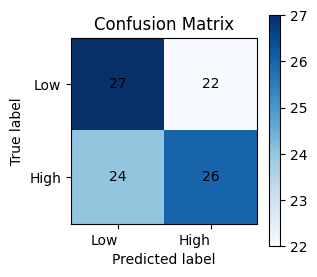

In [ ]:
# Model
Na=N
cluster=2
X=np.asarray(N.iloc[:,6:11])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.k_2)

# Mapping
mapping = {'Low': 0, 'High': 1}
Y = [mapping[s] for s in Y]

# Evaluation
print(accuracy_score(y_pred, Y))
print(f1_score(Y, y_pred, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, y_pred)
labels = ['Low', 'High']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.savefig('KM_low_vs_high_ksolution2.png', dpi=300)
plt.show()

### Quartile OS (k=4)

- Clustering into 4 groups.

- More complex classification = harder to separate groups.

In [ ]:
# Model
Na=N
cluster=4
X=np.asarray(N.iloc[:,6:11])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.k_4)

# Mapping
mapping = {'Low': 0, 'modlow': 1, 'modhigh': 2, 'high': 3}
Y = [mapping[s] for s in Y]

# Evaluation
print(accuracy_score(y_pred, Y))
print(f1_score(Y, y_pred, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, y_pred)
labels = ['Low', 'modlow', 'modhigh', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_low_vs_high_ksolution2.png', dpi=300)
plt.show()

#### Extreme OS Groups (Low vs. High from k=4)

- Only "Low" and "High" survival groups from quartiles are kept.


(50, 5)
0.54
0.5066495066495067


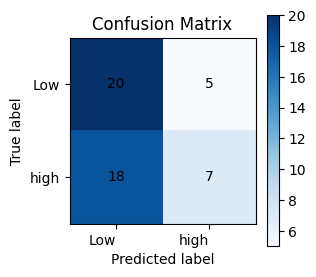

In [ ]:
# Model
Na = N[(N.k_4 == 'Low') | (N.k_4 == 'high')]
cluster=2
X=np.asarray(Na.iloc[:,6:11])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.k_4)

# Mapping
mapping = {'Low': 0, 'high': 1}
Y = [mapping[s] for s in Y]

# Evaluation
print(accuracy_score(y_pred, Y))
print(f1_score(Y, y_pred, average='weighted'))

# Confusion matrix
cm = confusion_matrix(Y, y_pred)
labels = ['Low', 'high']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_low_vs_high_ksolution4.png', dpi=300)
plt.show()

### Quintile OS (k=5, Extreme Groups Only)

- Clustering only extreme quintile groups.

(40, 5)
0.525
0.5174603174603174


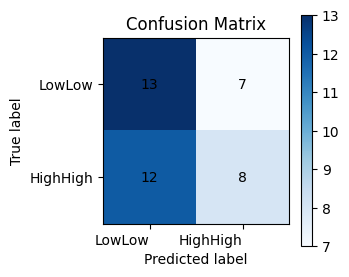

In [ ]:
# Model
Na = N[(N.k_5 == 'LowLow') | (N.k_5 == 'HighHigh')]
cluster=2
X=np.asarray(Na.iloc[:,6:11])
print(X.shape)
#kmeans = KMeans(n_clusters=cluster, random_state=3)
kmeans = KMeans(n_clusters=cluster, random_state=1)

# Prediction
y_pred = kmeans.fit_predict(X)
Y=np.asarray(Na.k_5)

# Mapping
mapping = {'LowLow': 0, 'HighHigh': 1}
Y = [mapping[s] for s in Y]
print(accuracy_score(y_pred, Y))
print(f1_score(Y, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(Y, y_pred)
labels = ['LowLow', 'HighHigh']
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
#plt.savefig('confusion_martix_PCFDC_PC1.png', dpi=300, bbox_inches='tight')
plt.savefig('KM_low_vs_high_ksolution5.png', dpi=300)
plt.show()

# 6. NETWORK ANALYSIS

## Mean Functional Connectivity Strength Analysis

#### Dataset

- A is the transposed functional connectivity matrix:

    - Rows = Subjects

    - Columns = Brain regions/voxels.

- Preprocessing

In [ ]:
# Load the dataset
dfmgmt=pd.read_excel('PD_dataset.xlsx', sheet_name='Sheet14')
A=df.T

#A['group']=dfmgmt['GRUOP_OS']

# Replace Zeros with NaN
A = A.replace(0, np.nan)

# Calculate the average for each subject (row)
A['average'] = A.mean(axis=1)

In [ ]:
# Strength DataFrame
strenght=pd.DataFrame(A['average'])

# Survival group labels
strenght['group']=dfmgmt.GRUOP_OS

#### Statistical Analysis

Check:

- Check Homogeneity of Variance

- Mean for each group

- One-Way ANOVA:

    - ANOVA tests whether FC means differ significantly across survival groups.

    - If p-value < 0.05 → Significant difference in FC across OS groups.

In [ ]:
print(pg.homoscedasticity(strenght, group='group', dv='average'))
print('low',strenght['average'][strenght.group=='low'].mean())
print('high',strenght['average'][strenght.group=='high'].mean())
print('intermediate',strenght['average'][strenght.group=='intermediate'].mean())
aov=pg.anova(data=strenght, dv='average', between='group')
aov

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
strenght

#### Data Visualization: Boxplot of Mean FC Strength

In [ ]:
fig, f = plt.subplots(1, figsize=(8,7))
f=sns.boxplot(y='average', x='group', data=strenght, palette="colorblind", 
              showfliers = False, notch=True)
f=sns.stripplot(y='average', x='group', data=strenght, color='black', alpha=0.6, size=8)
plt.ylim(0.21, 0.36)  # Set the desired lower and upper limits for the y-axis
t='pval='+str(round(aov['p-unc'][0],3))

text_kwargs = dict(fontsize=12)
f.text(-0.25, 0.345, t, style='italic', **text_kwargs,
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 8})

plt.savefig('FC_strenght.png', dpi=300)

1. Store and Delete Previous Mean FC Values

2. Reload and Transpose the Functional Connectivity Matrix

## Mean Functional Connectivity Maps

#### Dataset restoration

Restoring the Original Functional Connectivity Data and reintroducing the Group Labels

In [ ]:
# Delete Previous Values
col_average=A.average
del A

# Reload
A=df.T
A['group']=dfmgmt.GRUOP_OS

# Separate data by surival 
Al=A[A.group=='low']
Ai=A[A.group=='intermediate']
Ah=A[A.group=='high']

Al = Al.drop(columns=['group'])

#### Compute Mean FC Map for Low OS Group

In [ ]:
avg_al = Al.mean(axis=0)
avg_al=np.asarray(avg_al)
mapnii1=avg_al.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='Low_FCmean.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.3, colorbar=True)
plt.savefig('meanFC_low.png', dpi=300, bbox_inches='tight')
plt.show()

#### Compute Mean FC Map for Intermediate OS Group

In [ ]:
avg_ai = Ai.mean(axis=0)
avg_ai=np.asarray(avg_ai)
mapnii1=avg_ai.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='Intermediate_FCmean.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.3, colorbar=True)
plt.savefig('meanFC_intermediate.png', dpi=300, bbox_inches='tight')
plt.show()

#### Compute Mean FC Map for High OS Group

In [ ]:
avg_ah = Ah.mean(axis=0)
avg_ah=np.asarray(avg_ah)
mapnii1=avg_ah.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='High_FCmean.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/Under_Review_PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.3, colorbar=True)
plt.savefig('meanFC_high.png', dpi=300, bbox_inches='tight')
plt.show()

#### Load the Functional Connectivity Maps

In [ ]:
hg_map=nib.load('High_FCmean.nii.gz').get_fdata().flatten()
lw_map=nib.load('Low_FCmean.nii.gz').get_fdata().flatten()
it_map=nib.load('Intermediate_FCmean.nii.gz').get_fdata().flatten()

#### Scatter Plots for Each Pair of Survival Groups

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(hg_map,lw_map, linewidth=0.8, color='salmon', edgecolor='k')
ax[1].scatter(hg_map,it_map, linewidth=0.8, color='gold', edgecolor='k')
ax[2].scatter(it_map,lw_map, linewidth=0.8, color='limegreen', edgecolor='k')

aaaa=round(stats.pearsonr(hg_map,lw_map)[0],3)
bbbb=round(stats.pearsonr(hg_map,it_map)[0],3)
cccc=round(stats.pearsonr(lw_map,it_map)[0],3)

ax[0].text(0.05, 0.4, aaaa, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 8})

ax[1].text(0.05, 0.4, bbbb, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 8})

ax[2].text(0.05, 0.4, cccc, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 8})

plt.savefig('scatter_meanMap_OS.png', dpi=300)

## Network-Level Analysis Using Yeo Templates

> *Moreover, for each participant, network maps were associated to a specific Yeo’s map through a “winner-take-all-approach” based on spatial correlation (Pearson’s coefficient). A chi square statistic was applied to investigate whether OS groups showed a different distribution on network assignments. Additionally, we carried out an additional analysis to assess the differences in correlation between network maps and network templates between groups using a repeated measures ANOVA. This analysis included the network template as the within factor and group as the between factor. The interaction between group and network was significant at p < 0.05.*

#### Load Yeo network templates

In [ ]:
VIS=nib.load('Yeo_NET/VIS.nii.gz').get_fdata().flatten()
VAN=nib.load('Yeo_NET/SN.nii.gz').get_fdata().flatten()
DAN=nib.load('Yeo_NET/DAN.nii.gz').get_fdata().flatten()
DMN=nib.load('Yeo_NET/DMN.nii.gz').get_fdata().flatten()
LMB=nib.load('Yeo_NET/LMB.nii.gz').get_fdata().flatten()
FPN=nib.load('Yeo_NET/FPN.nii.gz').get_fdata().flatten()
SMN=nib.load('Yeo_NET/SMN.nii.gz').get_fdata().flatten()

In [ ]:
A=A.drop(columns=['group'])

#### Compute Pearson Correlations

For each subject, computes Pearson correlation between their FC pattern and each Yeo network.

In [ ]:
st_VIS=[]
st_SMN=[]
st_FPN=[]
st_DMN=[]
st_LMB=[]
st_VAN=[]
st_DAN=[]

for x in range(len(A)):
    st_VIS.append(stats.pearsonr(A.loc[x], VIS)[0])
    st_DAN.append(stats.pearsonr(A.loc[x], DAN)[0])
    st_VAN.append(stats.pearsonr(A.loc[x], VAN)[0])
    st_DMN.append(stats.pearsonr(A.loc[x], DMN)[0])
    st_FPN.append(stats.pearsonr(A.loc[x], FPN)[0])
    st_SMN.append(stats.pearsonr(A.loc[x], SMN)[0])
    st_LMB.append(stats.pearsonr(A.loc[x], LMB)[0])

#### Store Correlations in a DataFrame & Visualize

In [ ]:
F={'SMN':st_SMN, 'VIS':st_VIS,
   'VAN':st_VAN,'DAN':st_DAN,
   'FPN':st_FPN,'DMN':st_DMN,
   'LMB':st_LMB}
df_corr=pd.DataFrame(F)

#### Statistical Analysis

In [ ]:
fig, f = plt.subplots(1, figsize=(14,6))
rainbow_palette = sns.color_palette('rainbow')
sns.boxplot(df_corr, showfliers=False, palette=rainbow_palette, width=1, notch=False)
f=sns.stripplot(df_corr, color='black', alpha=0.4, size=6)
plt.savefig('Network_correlation.png', dpi=300)

In [ ]:
concatenated_df = pd.melt(df_corr, value_vars=df_corr.columns,
                          var_name='Label', value_name='Value')
print(pg.homoscedasticity(concatenated_df, group='Label', dv='Value'))
aov=pg.welch_anova(data=concatenated_df, dv='Value', between='Label')
print(aov)
pg.pairwise_gameshowell(data=concatenated_df, dv='Value', between='Label')

## Winner-Take-All Network Classification & Survival Prediction

In [ ]:
A = A.replace(0, np.nan)
A['average'] = A.mean(axis=1)

In [ ]:
pos=[]
for x in range(len(df_corr)):
    pos.append(np.where(df_corr.loc[x] == np.amax(df_corr.loc[x]))[0][0])
A['Network']=pos
B = A[["Network", "average"]]
fig, f = plt.subplots(1, figsize=(14,6))
rainbow_palette = sns.color_palette('rainbow')
sns.boxplot(B, showfliers=False, x='Network', y='average', palette=rainbow_palette, width=1, notch=False)
f=sns.stripplot(B, x='Network', y='average', color='black', alpha=0.4, size=10)
plt.savefig('Network_WinnerTakeAll_strenght.png', dpi=300)

In [ ]:
df_corr['OS']=os.OS_months
# Load the data
X = df_corr.iloc[:, 0:6]
Y = df_corr['OS']  

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
alphas = np.linspace(0.000001, 100, 100)
loo = LeaveOneOut()

steps = [
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas=alphas, cv=loo, random_state=12))
]

pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)

best_alpha = pipeline.named_steps['lasso'].alpha_
print(f'Best alpha: {best_alpha}')

lasso_best = Lasso(alpha=best_alpha, random_state=0)
lasso_best.fit(x_train, y_train)

lasso_best_score = lasso_best.score(x_test, y_test)
print(f'Lasso with best alpha score on test set: {lasso_best_score}')
y_pred=lasso_best.predict(x_test)
print(r2_score(y_test,y_pred))
plt.scatter(y_test,y_pred)

In [ ]:
C=B[B.Network!=6]
print(len(B), len(C))

pd.set_option('display.max_rows', None)
print(pg.homoscedasticity(C, group='Network', dv='average'))
aov=pg.welch_anova(data=C, dv='average', between='Network')
print(aov)
pg.pairwise_gameshowell(data=C, dv='average', between='Network')

In [ ]:
C['Group']=dfmgmt.GRUOP_OS
C.drop(columns='average', inplace=True)
associations = {0: 'SMN', 1: 'VIS', 2: 'VAN', 3: 'DAN', 4: 'FPN', 5: 'DMN', 6: 'LMB'}
C['Network'] = C['Network'].replace(associations)

In [ ]:
from scipy.stats import chi2_contingency
contigency = pd.crosstab(C['Network'], C['Group'], normalize=False)
plt.figure(figsize=(7,5)) 
sns.heatmap(contigency, annot=False, cmap="gray_r")
c, p, dof, expected = chi2_contingency(contigency) # Print the p-value
print(p)
plt.savefig('contingency_map_3OSgroups.png', dpi=300)

In [ ]:
C2=C[C.Group!='intermediate']
contigency = pd.crosstab(C2['Network'], C2['Group'], normalize=False)
plt.figure(figsize=(4,4)) 
sns.heatmap(contigency, annot=False, cmap="gray_r")
c, p, dof, expected = chi2_contingency(contigency) # Print the p-value
print(p)
plt.savefig('contingency_map_High_Low.png', dpi=300)

In [ ]:
### REVISION - ENSURE WINNER-TAKE-ALL-APPROACH

fig, ax= plt.subplots(2,2, figsize=(12,8))
df_corr_ordered=df_corr.sort_values(by=['SMN'], ascending=False)
sns.heatmap(df_corr_ordered, vmax=0.6, vmin=0.1, cmap='coolwarm', ax=ax[0,0])
df_corr_ordered=df_corr.sort_values(by=['VIS'], ascending=False)
first_column = df_corr_ordered.pop('VIS') 
df_corr_ordered.insert(0, 'VIS', first_column) 
sns.heatmap(df_corr_ordered, vmax=0.6, vmin=0.1, cmap='coolwarm', ax=ax[0,1])
df_corr_ordered=df_corr.sort_values(by=['DMN'], ascending=False)
first_column = df_corr_ordered.pop('DMN') 
df_corr_ordered.insert(0, 'DMN', first_column) 
sns.heatmap(df_corr_ordered, vmax=0.6, vmin=0.1, cmap='coolwarm', ax=ax[1,0])

df_corr_ordered=df_corr.sort_values(by=['FPN'], ascending=False)
first_column = df_corr_ordered.pop('FPN') 
df_corr_ordered.insert(0, 'FPN', first_column) 
sns.heatmap(df_corr_ordered, vmax=0.6, vmin=0.1, cmap='coolwarm', ax=ax[1,1])

plt.savefig('take_all.png', dpi=300)

In [ ]:
df_corr['Group']=dfmgmt.GRUOP_OS
df_corr.insert(0, 'SubjID', range(len(df_corr)))
df_long = df_corr.melt(id_vars=['Group', 'SubjID'], var_name='Network', value_name='Value')
df_long['SubjID']=df_long['SubjID'].astype('str')
df_long.dtypes

In [ ]:
df_long = df_corr.melt(id_vars=['Group', 'SubjID'], var_name='Network', value_name='Value')
df_long['SubjID']=df_long['SubjID'].astype('str')
df_long.dtypes

In [ ]:
pg.mixed_anova(dv='Value', between='Group', within='Network', 
                subject='SubjID', data=df_long)
# pairwise tests
#pg.pairwise_ttests(data=df_long, dv='Value', between='Group', 
#                    within='Network', subject='SubjID')

In [ ]:
from patsy.contrasts import Treatment
from statsmodels.formula.api import mixedlm
# Define the formula with a specified reference level for Group
formula = "Value ~ C(Network)*C(Group, Treatment(reference='low'))"

# Fit mixed ANOVA model
model = mixedlm(formula, data=df_long, groups=df_long["SubjID"])
result = model.fit()

print(result.summary())

In [ ]:
import statsmodels.api as sm

# Fit mixed ANOVA model
model = mixedlm("Value ~ C(Network)*C(Group)", data=df_long, 
                groups=df_long["SubjID"])
result = model.fit()

print(result.summary())

# 7. PCA ON SURVIVAL GROUPS

In [ ]:
%reset -f
import math
import glob
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nib
import seaborn as sns
from scipy import stats
import umap.umap_ as umap
from nilearn import plotting
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_decomposition import PLSRegression
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split

## Low survival <6 months

In [ ]:
path='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/LOW/*gz'
mapsPCFDC=[]
files=glob.glob(path)
for x in range(len(files)):
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

df = df.mask(df < 0.2, 0) # MAKS VALUES LOWER THAN 0.2

In [ ]:
pca_PCFDC=PCA()
pca_components=pca_PCFDC.fit_transform(df)

mo_all,kmo_model=calculate_kmo(df)
text= 'kmo='+str(round(kmo_model,3))
print('kmo is', text)
print('')
percentage_var_explained = pca_PCFDC.explained_variance_ / np.sum(pca_PCFDC.explained_variance_);
percentage_var_explained100=percentage_var_explained*100
cum_var_dist=np.cumsum(pca_PCFDC.explained_variance_ratio_)

In [ ]:
n_comp=10
g=cum_var_dist[:n_comp]*100
y=np.arange(1,n_comp+1)
plt.figure(figsize=(9, 4), dpi=80)
perc=percentage_var_explained100[0:n_comp]
plt.bar(y,perc)
plt.grid()
plt.scatter(y,g)
plt.plot(y,g)
plt.ylim([0, 100])
lll=np.where(cum_var_dist>0.90)[0][0]
text2='N comp > 90% ='+str(lll)
text_kwargs = dict(fontsize=14)
#plt.text(0.9, 50, text_voxel_unflip, style='italic', **text_kwargs,
#        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
plt.text(3, 40, text2, style='italic', fontsize=14,
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
m='low.png'
plt.savefig(m, dpi=300, bbox_inches='tight')
print(percentage_var_explained100[0:10])

In [ ]:
# SAVE FIRST PC
pc1=pca_components[:,0]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc1
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC1_LOW.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=.5, colorbar=False)
plt.savefig('PC1_low.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
del df, mapsPCFDC, files, aff, d, pca_PCFDC, pca_components, kmo_model, percentage_var_explained

## Intermediate survival (6-20 months)

In [ ]:
path='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/INTERMEDIATE/*gz'
mapsPCFDC=[]
files=glob.glob(path)
for x in range(len(files)):
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

df = df.mask(df < 0.2, 0) # MAKS VALUES LOWER THAN 0.2

In [ ]:
pca_PCFDC=PCA()
pca_components=pca_PCFDC.fit_transform(df)

mo_all,kmo_model=calculate_kmo(df)
text= 'kmo='+str(round(kmo_model,3))
print('kmo is', text)
print('')
percentage_var_explained = pca_PCFDC.explained_variance_ / np.sum(pca_PCFDC.explained_variance_);
percentage_var_explained100=percentage_var_explained*100
cum_var_dist=np.cumsum(pca_PCFDC.explained_variance_ratio_)

In [ ]:
n_comp=10
g=cum_var_dist[:n_comp]*100
y=np.arange(1,n_comp+1)
plt.figure(figsize=(9, 4), dpi=80)
perc=percentage_var_explained100[0:n_comp]
plt.bar(y,perc)
plt.grid()
plt.scatter(y,g)
plt.plot(y,g)
plt.ylim([0, 100])
lll=np.where(cum_var_dist>0.90)[0][0]
text2='N comp > 90% ='+str(lll)
text_kwargs = dict(fontsize=14)
#plt.text(0.9, 50, text_voxel_unflip, style='italic', **text_kwargs,
#        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
plt.text(3, 40, text2, style='italic', fontsize=14,
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
m='intermediate.png'
plt.savefig(m, dpi=300, bbox_inches='tight')
print(percentage_var_explained100[0:10])

In [ ]:
# SAVE FIRST PC
pc2=pca_components[:,0]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc2
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC1_INTERMEDIATE.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=.3, colorbar=False)
plt.savefig('PC1_INTERMEDIATE.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
del df, mapsPCFDC, files, aff, d, pca_PCFDC, pca_components, kmo_model, percentage_var_explained

## High survival (>20 months)

In [ ]:
path='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/HIGH/*gz'
mapsPCFDC=[]
files=glob.glob(path)
for x in range(len(files)):
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

df = df.mask(df < 0.2, 0) # MAKS VALUES LOWER THAN 0.2

In [ ]:
pca_PCFDC=PCA()
pca_components=pca_PCFDC.fit_transform(df)

mo_all,kmo_model=calculate_kmo(df)
text= 'kmo='+str(round(kmo_model,3))
print('kmo is', text)
print('')
percentage_var_explained = pca_PCFDC.explained_variance_ / np.sum(pca_PCFDC.explained_variance_);
percentage_var_explained100=percentage_var_explained*100
cum_var_dist=np.cumsum(pca_PCFDC.explained_variance_ratio_)

In [ ]:
n_comp=10
g=cum_var_dist[:n_comp]*100
y=np.arange(1,n_comp+1)
plt.figure(figsize=(9, 4), dpi=80)
perc=percentage_var_explained100[0:n_comp]
plt.bar(y,perc)
plt.grid()
plt.scatter(y,g)
plt.plot(y,g)
plt.ylim([0, 100])
lll=np.where(cum_var_dist>0.90)[0][0]
text2='N comp > 90% ='+str(lll)
text_kwargs = dict(fontsize=14)
#plt.text(0.9, 50, text_voxel_unflip, style='italic', **text_kwargs,
#        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
plt.text(3, 40, text2, style='italic', fontsize=14,
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
m='high.png'
plt.savefig(m, dpi=300, bbox_inches='tight')
print(percentage_var_explained100[0:10])

In [ ]:
# SAVE FIRST PC
pc2=pca_components[:,0]
comp1=pd.DataFrame(df.index)
comp1['scores']=pc2
comp1.columns=['Parcel', 'Scores']
#mask=nib.load('leftmask.2mm.nii.gz')
f=np.asarray(comp1.Scores)
mapnii1=f.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='PC1_HIGH.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='coolwarm', threshold=0.3, colorbar=False)
plt.savefig('PC1_HIGH.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlation pattern maps

In [ ]:
import seaborn as sns

In [ ]:
mri_file_low_pc1 = "PC1_LOW.nii.gz"   
mri_file_high_pc1 = "PC1_HIGH.nii.gz"   
mri_file_intermediate_pc1 = "PC1_INTERMEDIATE.nii.gz"   

A=nib.load(mri_file_low_pc1).get_fdata().flatten()
B=nib.load(mri_file_high_pc1).get_fdata().flatten()
C=nib.load(mri_file_intermediate_pc1).get_fdata().flatten()
df=pd.DataFrame([A,B,C]).T
A=df.corr()

In [ ]:
A

In [ ]:
sns.heatmap(A, vmax=1, vmin=0.98, cmap='gray_r')
plt.savefig('mcorr_matrix.png', dpi=300)

In [2]:
path= '/data/FCmaps_mean_temp/*gz'
mapsPCFDC=[]
files=glob.glob(path)
files.sort()

# Loop over files
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

# Mask values lower than 0.2
df = df.mask(df < 0.2, 0) 

# Add Subject Identifiers
files_ = [sub.replace('/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99_subjs/meanFC.', '') for sub in files]
files_ = [sub.replace('.nii.gz', '') for sub in files_]
df_fdc=df.T
df_fdc.insert(loc = 0, column = 'CODE', value = files_)

/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/FCmaps_mean/012_S_4188.FDC.nii.gz

# 8. Connectivity projection into a 2D space

> *Finally, we explored the relationship between indirect functional connectivity and OS projecting the thresholded PC-FDC maps into a 2D space by means of the Uniform Manifold Approximation and Projection (UMAP) algorithm, a non-linear embedding approach that distributes data variability along major axes (McInnes et al., 2018).* [...]

## UMAP and GMM

#### Load data and preprocessing

#### Apply Grey Matter Mask

- binary mask of grey matter using the Harvard-Oxford Atlas

- FSL, a popular neuroimaging tool.

- `-bin` → Converts probability values into binary (0 or 1)

In [ ]:
%%bash
fslmaths \
   /home/lorenzo/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr50-2mm.nii.gz \
   -bin \
   mask_GM

In [6]:
# Loads the GM mask and flatten it
mask=nib.load('/data_utils/mask_GM.nii').get_fdata().flatten()

dfT=df.T

print(dfT.shape)
#dfT.head(4)

(51, 902629)


In [7]:
new_row_df = pd.DataFrame([mask], columns=dfT.columns)

# Append the Mask as the Last Row
dfT = pd.concat([dfT, new_row_df], ignore_index=True)

print(dfT.shape)
#dfT.tail(4)

(52, 902629)


#### Load Survival Data and prepocessing

In [ ]:
# Load survival data
os = pd.read_excel('OS_the_99_subjs.xlsx')  

# Insert survival months into the dataframe
dfT.insert(loc=0, column='OS', value=os.OS_months)  

# Creates a new categorical column
dfT['OS_category'] = dfT['OS'].apply(lambda x: 'Low' if x < 6 else ('Interm' if 6 <= x <= 20 else 'High'))

In [8]:
# Remove what is not atlas 
dfT2 = dfT.loc[:, (dfT.iloc[-1] != 0)]
print(dfT2.shape)

(52, 55004)


In [ ]:
OS_cat=dfT2['OS_category']
X=dfT2.drop(columns=['OS','OS_category'])
X = X.drop(X.index[-1])
print(X.shape)

In [10]:
# My part
X = dfT2.copy()
X = X.drop(X.index[-1])
print(X.shape)

(51, 55004)


#### Dimensionality Reduction with UMAP

In [12]:
import umap

In [13]:
reducer = umap.UMAP(n_neighbors=15, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings.
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different.
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded.
              )
X_trans = reducer.fit_transform(X)

/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### Cluster UMAP Results with GMM

In [ ]:
OS_cat2=OS_cat.iloc[:-1] # remove the last value (based on Nan due to the inclusion of the mask)

- Applies Gaussian Mixture Model (GMM) clustering on the UMAP-reduced data (X_trans).

- Uses 3 clusters, assuming that the functional connectivity might naturally cluster into three survival groups

In [ ]:
clustering_gmm = GaussianMixture(n_components=3, random_state=42)

labels_gmm = clustering_gmm.fit_predict(X_trans)
assignedUMAP=pd.DataFrame({'labels':labels_gmm,
                           'X1':X_trans[:,0],
                           'X2':X_trans[:,1],
                           'OS':OS_cat2})
assignedUMAP['code']=files_

#### Visualize results

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(y=X_trans[:,0], x=X_trans[:,1], 
            hue=OS_cat2, s=140, palette='Set1', ax=ax[0],legend=False)

sns.scatterplot(y='X1', x='X2', hue='labels',legend=True,
                s=140, palette='Set1', data=assignedUMAP, ax=ax[1])

plt.savefig('UMAP_volume.png', dpi=300)
#assignedUMAP.to_excel('UMAP.xlsx')
#lab0=assignedUMAP.code[assignedUMAP.labels==0]

In [ ]:
print('variance explained by UMAP components')
#MNIST variation explained by UMAP1
for dimension in range(X_trans.shape[1]):
    UMAP_matrix = pd.DataFrame(X_trans[:, dimension:dimension+1])
    pls = PLSRegression(n_components = 1)
    pls.fit(UMAP_matrix, X)
    y_pred = pls.predict(UMAP_matrix)
    print(r2_score(X, y_pred, multioutput = 'variance_weighted'))

#### Compute Cluster-Averaged Connectivity Maps

In [ ]:
#lab0 = assignedUMAP.code[(assignedUMAP.labels == 0) & (assignedUMAP.X2 < -1.8)]
# Selects subjects assigned to cluster x
lab0 = assignedUMAP.code[(assignedUMAP.labels == 0)]
print(lab0.shape)
lab0_max=lab0
df_fdc_lab0 = df_fdc[df_fdc.CODE.isin(lab0)]
df_fdc_lab0=df_fdc_lab0.drop(columns='CODE')

# Computes mean functional connectivity map for this group
mean_values = np.asarray(df_fdc_lab0.mean())
mapnii1=mean_values.reshape(91,109,91)

# Saves the map
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='Label0_UMAP_GMM.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)

# Uses nilearn to visualize it
plotting.plot_glass_brain(mapfinal1, cmap='viridis', threshold=0.2, vmax=0.4, colorbar=True)
#plt.savefig('meanFC_low.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%bash
wb_command -volume-to-surface-mapping \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.nii.gz \
    /home/lorenzo/Desktop/ColeAnticevicNetPartition-master/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.left.shape.gii \
    -trilinear

wb_command -volume-to-surface-mapping \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.nii.gz \
    /home/lorenzo/Desktop/ColeAnticevicNetPartition-master/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.right.shape.gii \
    -trilinear
    
 wb_view \
    /home/lorenzo/Desktop/ColeAnticevicNetPartition-master/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii \
    /home/lorenzo/Desktop/ColeAnticevicNetPartition-master/S1200.R.very_inflated_MSMAll.32k_fs_LR.surf.gii \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.left.shape.gii \
    /home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/Label0_UMAP_GMM.right.shape.gii    

In [ ]:
lab1=assignedUMAP.code[assignedUMAP.labels==1]
#lab1 = assignedUMAP.code[(assignedUMAP.labels == 1) & (assignedUMAP.X1 > 9.5)]
print(lab1.shape)
df_fdc_lab1 = df_fdc[df_fdc.CODE.isin(lab1)]
df_fdc_lab1=df_fdc_lab1.drop(columns='CODE')
mean_values = np.asarray(df_fdc_lab1.mean())
mapnii1=mean_values.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='Label1_UMAP_GMM.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='viridis', threshold=0.2, vmax=0.4, colorbar=True)
#plt.savefig('meanFC_low.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
lab2=assignedUMAP.code[assignedUMAP.labels==2]
df_fdc_lab2 = df_fdc[df_fdc.CODE.isin(lab2)]
df_fdc_lab2=df_fdc_lab2.drop(columns='CODE')
mean_values = np.asarray(df_fdc_lab2.mean())
mapnii1=mean_values.reshape(91,109,91)
mapfinal1 = nib.nifti1.Nifti1Image(mapnii1, aff)
m='Label2_UMAP_GMM.nii.gz'
dirpath='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/'
save=dirpath+m
nib.save(mapfinal1, save)
plotting.plot_glass_brain(mapfinal1, cmap='viridis', threshold=0.2, vmax=0.4, colorbar=True)
#plt.savefig('meanFC_low.png', dpi=300, bbox_inches='tight')
plt.show()

## Surface-Based UMAP

- Converts volumetric (.nii.gz) brain maps into surface-based 

- Uses FreeSurfer’s fsaverage template for alignment

### Left Hemisphere Data

Load Left Hemisphere Surface Data

In [ ]:
path_surf_lh='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99subj_PCFDC_maps_surface_lh/*lh.mgh'
mapsPCFDC_surf_lh=[]
files_surf_lh=glob.glob(path_surf_lh)
files_surf_lh.sort()

for x in range(len(files_surf_lh)):
    print(files_surf_lh[x])
    d=nib.load(files_surf_lh[x]).get_fdata().flatten()
    mapsPCFDC_surf_lh.append(d)
df_surf_lh=pd.DataFrame(mapsPCFDC_surf_lh)

Merge Surface Data with Survival Information

In [ ]:
os=pd.read_excel('OS_the_99_subjs.xlsx')
df_surf_lh.insert(loc=0, column='OS', value=os.OS_months)
df_surf_lh['OS_category'] = df_surf_lh['OS'].apply(lambda x: 'Low' if x < 6 else ('Interm' if 6 <= x <= 20 else 'High'))
print(df_surf_lh.shape)
df_surf_lh.tail(4)

In [ ]:
OS_cat=df_surf_lh['OS_category']
X_surf_lh=df_surf_lh.drop(columns=['OS','OS_category'])
print(X_surf_lh.shape)

UMAP for Dimensionality Reduction

In [ ]:
reducer = umap.UMAP(n_neighbors=15, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )
X_trans = reducer.fit_transform(X_surf_lh)

Visualize the UMAP Projection

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,6))
sns.scatterplot(y=X_trans[:,0], x=X_trans[:,1], 
                hue=OS_cat, s=140, palette='Set1')
plt.savefig('UMAP_left_surface.png', dpi=300)

#### Compute Variance Explained

In [ ]:
print('variance explained by UMAP components')
#MNIST variation explained by UMAP1
for dimension in range(X_trans.shape[1]):
    UMAP_matrix = pd.DataFrame(X_trans[:, dimension:dimension+1])
    pls = PLSRegression(n_components = 1)
    pls.fit(UMAP_matrix, X_surf_lh)
    y_pred = pls.predict(UMAP_matrix)
    print(r2_score(X_surf_lh, y_pred, multioutput = 'variance_weighted'))

In [ ]:
del df_surf_lh, X, X_trans

### Right Hemisphere Data

Loads right hemisphere surface-based maps

In [ ]:
path_surf_rh='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99subj_PCFDC_maps_surface_rh/*rh.mgh'
mapsPCFDC_surf_rh=[]
files_surf_rh=glob.glob(path_surf_rh)
files_surf_rh.sort()

for x in range(len(files_surf_rh)):
    print(files_surf_rh[x])
    d=nib.load(files_surf_rh[x]).get_fdata().flatten()
    mapsPCFDC_surf_rh.append(d)
df_surf_rh=pd.DataFrame(mapsPCFDC_surf_rh)

Merges survival data with right hemisphere maps.

In [ ]:
os=pd.read_excel('OS_the_99_subjs.xlsx')
df_surf_rh.insert(loc=0, column='OS', value=os.OS_months)
df_surf_rh['OS_category'] = df_surf_rh['OS'].apply(lambda x: 'Low' if x < 6 else ('Interm' if 6 <= x <= 20 else 'High'))
print(df_surf_rh.shape)
df_surf_rh.tail(4)

In [ ]:
OS_cat=df_surf_rh['OS_category']
X_surf_rh=df_surf_rh.drop(columns=['OS','OS_category'])
print(X_surf_rh.shape)

UMAP for Dimensionality Reduction

In [ ]:
reducer = umap.UMAP(n_neighbors=15, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )
X_trans = reducer.fit_transform(X_surf_rh)

Plots the UMAP results for right hemisphere.

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,6))
sns.scatterplot(y=X_trans[:,0], x=X_trans[:,1], 
                hue=OS_cat, s=140, palette='Set1')
plt.savefig('UMAP_right_surface.png', dpi=300)

Computes variance explained by UMAP components for right hemisphere

In [ ]:
print('variance explained by UMAP components')
#MNIST variation explained by UMAP1
for dimension in range(X_trans.shape[1]):
    UMAP_matrix = pd.DataFrame(X_trans[:, dimension:dimension+1])
    pls = PLSRegression(n_components = 1)
    pls.fit(UMAP_matrix, X_surf_rh)
    y_pred = pls.predict(UMAP_matrix)
    print(r2_score(X_surf_rh, y_pred, multioutput = 'variance_weighted'))

# 9. HUNGARIAN ALGORITHM

### Data

In [ ]:
# Load Functional Connectivity Data
path='/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99_subjs/*gz'
mapsPCFDC=[]
files=glob.glob(path)
files.sort()

for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    mapsPCFDC.append(d)
aff=nib.load(files[0]).affine
df=pd.DataFrame(mapsPCFDC)
df=df.T

df = df.mask(df < 0.2, 0) # MAKS VALUES LOWER THAN 0.2

# Extract Subject Identifiers
files_ = [sub.replace('/home/lorenzo/Desktop/CODING/MY_PAPERS_ONGOING/PCFDC_June2023/the_99_subjs/meanFC.', '') for sub in files]
files_ = [sub.replace('.nii.gz', '') for sub in files_]
df_fdc=df.T
df_fdc.insert(loc = 0, column = 'CODE', value = files_)

In [ ]:
# Merge Survival Data
os=pd.read_excel('OS_the_99_subjs.xlsx')
df_fdc.insert(loc=1, column='OS', value=os.OS_months)
df_fdc.head(3)

### Hungarian Algorithm

In [ ]:
#fdc=df_fdc.T
import time
fdc=df_fdc
max_corr=[]
rval=[]
pred_diff=[]
perm_diff=[]

fig, ax = plt.subplots(1, figsize=(5, 3))

for random_seed in range(1000): # Run 1000 repetitions
    print(random_seed)
    s = time.time()
    # Split dataset into two equal halves
    fdc1, fdc2 = train_test_split(fdc, test_size=0.5, random_state=random_seed)

    # Remove last element to ensure square matrix
    fdc2 = fdc2[0: fdc2.shape[0] - 1]

    # Save separately OS and Name for later matching
    name1 = fdc1.CODE.tolist()
    OS1 = fdc1.OS.tolist()
    name2 = fdc2.CODE.tolist()
    OS2 = fdc2.OS.tolist()

    # Remove CODE and OS from dataset
    fdc1 = fdc1.loc[:, ~fdc1.columns.isin(['CODE', 'OS'])]
    fdc2 = fdc2.loc[:, ~fdc2.columns.isin(['CODE', 'OS'])]

    # Compute Pearson Correlation Matrix
    stat = []
    for x in range(len(fdc2)):
        for y in range(len(fdc1)):
            statistic = stats.pearsonr(fdc2.iloc[x], fdc1.iloc[y])[0]
            stat.append(statistic)

    # Replace NaN values with 0 and reshape matrix
    stat2_ = [0 if math.isnan(x) else x for x in stat]
    stat3 = np.asarray(stat2_).reshape(fdc2.shape[0], fdc1.shape[0])

    # Negative values become 0 (only positive correlations matter)
    stat3[stat3 < 0] = 0

    # Hungarian Algorithm: Find best matching subjects
    fdc2_ind_riga, fdc1_ind_colonna = linear_sum_assignment(stat3)

    # Reorder OS values based on the Hungarian assignment
    name1_ordered = [name1[i] for i in fdc1_ind_colonna]
    OS1_ordered = [OS1[i] for i in fdc1_ind_colonna]

    # Compute Pearson correlation of predicted vs. actual OS
    rval.append(stats.pearsonr(OS1_ordered, OS2)[0])
    pred_diff.append(np.asarray(OS1_ordered) - np.asarray(OS2))
    perm_diff.append(np.asarray(OS1) - np.asarray(OS2))

    e = time.time()
    print(e)
    print(stats.pearsonr(OS1_ordered, OS2)[0])
    print()

    # Plot regression line
    sns.regplot(x=OS1_ordered, y=OS2, ci=None, 
            scatter=False, line_kws={'linewidth': 1, 'color': 'gray', 'alpha': 0.5})

plt.title('Regression Line on the Same Graph')
plt.tight_layout()
plt.savefig('corr.png', dpi=300)
plt.show()

Plot Distribution of Prediction Accuracy

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,2))
sns.kdeplot(rval, fill=True, color='green')
sns.despine(left=True)
plt.axvline(max(rval), 
            color='red', linestyle='--')
plt.axvline(min(rval), 
            color='blue', linestyle='--')
plt.axvline(np.mean(rval), 
            color='k', linestyle='-')

plt.savefig('data_predOS_Rvalue_distribution_with1000repetitions.png', dpi=300)

In [ ]:
print(np.mean(rval))
print(np.max(rval))
print(np.min(rval))

#### Compare Hungarian Algorithm vs. Random Matching

In [ ]:
perm_diff_=np.asarray(perm_diff) #.flatten()
pred_diff_=np.asarray(pred_diff) #.flatten()

m=np.zeros(len(perm_diff_))
l=np.zeros(len(pred_diff_))
for pg in range(len(pred_diff_)):
    l[pg]=np.abs(np.median(pred_diff_[pg]))
    m[pg]=np.abs(np.median(perm_diff_[pg]))

In [ ]:
k=np.concatenate((l,m), axis=0)
dt_predOS=pd.DataFrame({'value':k,
                       'type':['random']*len(perm_diff_)+['pred']*len(perm_diff_)})

Violin Plot Comparison

In [ ]:
sns.set_style('white')
iris = sns.load_dataset('iris')
palette = 'Set2'
fig, ax = plt.subplots(1, figsize=(7,5))

ax = sns.violinplot(x="type", y="value", data=dt_predOS, dodge=False,
                    scale="width", inner=None,  palette=['orange','skyblue'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

sns.boxplot(x="type", y="value", 
            data=dt_predOS, saturation=1, showfliers=False,
            width=0.2, linewidth=2, 
            boxprops={'zorder': 3, 'facecolor': 'None', 'edgecolor': 'black'}, 
            medianprops={'color': 'black', 'linewidth': 2},
            whiskerprops={'color': 'black'},
            capprops={'color': 'black'},
            ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(x="type", y="value", palette=['red','dodgerblue'], 
              data=dt_predOS, dodge=False, alpha=0.9, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('comparing_random_and_Hungarianassignement_median_OSdiff.png', dpi=300)
plt.show()

Perform Paired t-Test

In [ ]:
stats.ttest_rel(dt_predOS.value[dt_predOS.type=='pred'], 
                dt_predOS.value[dt_predOS.type=='random'])

Compute MAE / RMSE

In [ ]:
Yp=[]
Yr=[]
for x in range(len(pred_diff)):
    far=pred_diff[x]
    Yp.append(np.sqrt(np.mean(np.square(far))))
    #Yp.append((np.mean(np.abs(far))))
for x in range(len(perm_diff)):
    far=perm_diff[x]
    Yr.append(np.sqrt(np.mean(np.square(far))))
    #Yr.append((np.mean(np.abs(far))))
    

In [ ]:
j=np.concatenate((Yp,Yr), axis=0)
dt_predOS_new=pd.DataFrame({'value':j,
                       'type':['pred']*len(pred_diff)+['random']*len(perm_diff)})

In [ ]:
sns.set_style('white')
iris = sns.load_dataset('iris')
palette = 'Set2'
fig, ax = plt.subplots(1, figsize=(7,5))

ax = sns.violinplot(x="type", y="value", data=dt_predOS_new, dodge=False,
                    scale="width", inner=None,  palette=['orange','skyblue'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

sns.boxplot(x="type", y="value", 
            data=dt_predOS_new, saturation=1, showfliers=False,
            width=0.2, linewidth=2, 
            boxprops={'zorder': 3, 'facecolor': 'None', 'edgecolor': 'black'}, 
            medianprops={'color': 'black', 'linewidth': 2},
            whiskerprops={'color': 'black'},
            capprops={'color': 'black'},
            ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(x="type", y="value", palette=['red','dodgerblue'], 
              data=dt_predOS_new, dodge=False, alpha=0.9, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('comparing_random_and_Hungarianassignement_median_OSdiff.png', dpi=300)
plt.show()

In [ ]:
stats.ttest_rel(dt_predOS_new.value[dt_predOS_new.type=='pred'], 
                dt_predOS_new.value[dt_predOS_new.type=='random'])

In [ ]:
print(dt_predOS_new[dt_predOS_new.type=='pred'].value.mean())
print(dt_predOS_new[dt_predOS_new.type=='random'].value.mean())